# Climate Change impact using eWaterCycle and HBV for Caravan catchments
The notebooks in this repo, when run in succesion, will analyse the impact of climate change on river discharge, for one region on earth, for four climate scenarios, based on one climate model.

Together these notebooks form a workflow. This workflow can be run multiple times for different regions, different climate scenarios or different climate models.

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

from cara import CaravanForcing

In [3]:
# Parameters
region_id = "hysets_01371500"
settings_path = "settings.json"

In [4]:
# Parameters
region_id = "camelsgb_22001"


## Choose region and time periods: 
In eWaterCycle we provide access to the Caravan dataset, which contains data for all the catchments in the different Camels datasets. In this notebook we select a region and load the caravan data from that region using eWatercycle.

However, there is a known problem with the caravan evaporation data and (the current version) shouldn't be used. It would be better to generate forcing from (for example) ERA5. So we are using the caravan data for two purposes in this set of notebooks:

- caravan has observed discharge data for the region which is used to calibrate HBV in step 2
- Caravan provides a shapefile of the region which is used to cut out the region from both ERA5 and CMIP climate output when generating forcing in step 1a and 1b

Using the interactive maps at [eWaterCycle caravan map](https://www.ewatercycle.org/caravan-map/) one can easily retrieve the identifier of the catchment you want to run for this analyses.

In the cells below we will identify the settings for all the notebooks, which we will save in a json file to be read by each notebook. This means that it is relatively easy to:

- change the region if you want to run just one catchment
- automate this to run for many catchments (which we will, of course, do in our own research)

First up: selecting the region. As "posterchild" for this study, we use the Rhine at Lobith.

In [5]:
settings = dict()

In [6]:
# settings["caravan_id"] = "hysets_01371500"
settings["caravan_id"] = region_id
	

We have to specify start and end dates of the experiment that we want to do. There should be a calibration and validation period for which observational data is available and a future period for which future climate simulations are available.

In [7]:
settings["calibration_start_date"] = "1994-08-01T00:00:00Z"
settings["calibration_end_date"] = "2004-07-31T00:00:00Z"

settings["validation_start_date"] = "2004-08-01T00:00:00Z"
settings["validation_end_date"] = "2014-07-31T00:00:00Z"

settings["future_start_date"] = "2029-08-01T00:00:00Z"
settings["future_end_date"] = "2049-08-31T00:00:00Z"

## Selecting climate change scenarios and climate model
A lot of different climate models exits and many of (the teams behind) them collaborate in CMIP: the Climate Model Intercomparison Project. Standardized output from these models is made available on ESGF nodes. In eWaterCycle, leveraging the work done on ESMValTool, we made a way to download forcing for hydrological models from those climate output dataset stored at ESGF nodes. 

CMIP, ESGF have a particular set of jargon to deal with, see [Juckes et al 2020](https://doi.org/10.5194/gmd-13-201-2020). Below we specify which datasets we will use for the climate change impact analyses



In [8]:
settings["CMIP_info"] = {"dataset" : ["MPI-ESM1-2-HR"],
                         # "ensembles" : ["r1i1p1f1",'r3i1p1f1'],
                         "ensembles" : ["r1i1p1f1"],
                         "experiments" : ["historical","ssp126","ssp245","ssp370","ssp585"],
                         "project" : "CMIP6",
                         "frequency" : "day",
                         "grid" : "gn",
                         "variables" : ["pr", "tas", "rsds"],
                        }

## Set up paths

Since forcing files are often re-used between experiments it is a best practice to save those intermediate files for re-use between experiments. These logical save-points in workflows are called 'rustpunten' in Dutch. It is important to store data in 'rustpunten' in standard formats. Working with clearly defined 'rustpunten' is a key element in the design of good workflows in general and was instrumental in designing eWaterCycle in particular. 

Here we set up some paths to store the forcing files we generate in your own home directory. 

In [9]:
# We will create a directory to store all data generated during this study
# normally we would not convert these back into strings and load as path objects
# all the time, but here this is done such that the settings can be written
# as json later on, which is impassable with PosixPath objects

home_path = Path("/gpfs/scratch1/shared/mmelotto/")
# home_path = Path.home()
home_path.mkdir(exist_ok=True, parents=True)

settings["base_path"] = str(home_path / "ewatercycleClimateImpact" / "HBV")

settings["path_caravan"] =  str(Path(settings["base_path"]) / "forcing_data" / settings["caravan_id"] / "caravan")
Path(settings["path_caravan"]).mkdir(exist_ok=True, parents=True)

settings["path_ERA5"] =  str(Path(settings["base_path"]) / "forcing_data" / settings["caravan_id"] / "ERA5")
Path(settings["path_ERA5"]).mkdir(exist_ok=True, parents=True)

settings["path_CMIP6"] =  str(Path(settings["base_path"]) / "forcing_data" / settings["caravan_id"] / "CMIP6")
Path(settings["path_CMIP6"]).mkdir(exist_ok=True, parents=True)

settings["path_output"] =  str(Path(settings["base_path"]) / "output_data" / settings["caravan_id"] )
Path(settings["path_output"]).mkdir(exist_ok=True, parents=True)

## Download caravan data: observation of discharge
There are three options for creating forcing data objects:

- generate from climate data such as Caravan, ERA5 or CMIP. Note that if the directory you specify as destination already contains data this trying this will throw an error!
- load forcing data you generated previously by providing the location where it was stored
- load forcing data someone else (such as your teacher or a workshop leader) generated previously by providing the location where it was stored


In [10]:
# Option one: generate forcing data
try:
    caravan_forcing_object = ewatercycle.forcing.sources['CaravanForcing'].load(directory=settings["path_caravan"])
except:
    caravan_forcing_object = CaravanForcing.generate(
        start_time=settings["calibration_start_date"],
        end_time=settings["validation_end_date"],
        directory=settings["path_caravan"],
        basin_id=settings["caravan_id"],
    )

# Note that this will throw an error when data is already present in `forcing_path_caravan`. In that case:
# - delete that data and run again or
# - load that data using the cell below (with the correct path!)

In [11]:
# Option two: load data that you or someone else generated previously
# caravan_forcing_object = ewatercycle.forcing.sources['CaravanForcing'].load(directory=settings["path_caravan"])

In [12]:
display(caravan_forcing_object)

CaravanForcing(start_time='1994-08-01T00:00:00Z', end_time='2014-07-31T00:00:00Z', directory=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22001/caravan'), shape=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22001/caravan/camelsgb_22001.shp'), filenames={'evspsblpot': 'camelsgb_22001_1994-08-01_2014-07-31_evspsblpot.nc', 'tasmax': 'camelsgb_22001_1994-08-01_2014-07-31_tasmax.nc', 'Q': 'camelsgb_22001_1994-08-01_2014-07-31_Q.nc', 'tas': 'camelsgb_22001_1994-08-01_2014-07-31_tas.nc', 'pr': 'camelsgb_22001_1994-08-01_2014-07-31_pr.nc', 'tasmin': 'camelsgb_22001_1994-08-01_2014-07-31_tasmin.nc'})

In [13]:
settings["path_shape"] = str(caravan_forcing_object.shape)

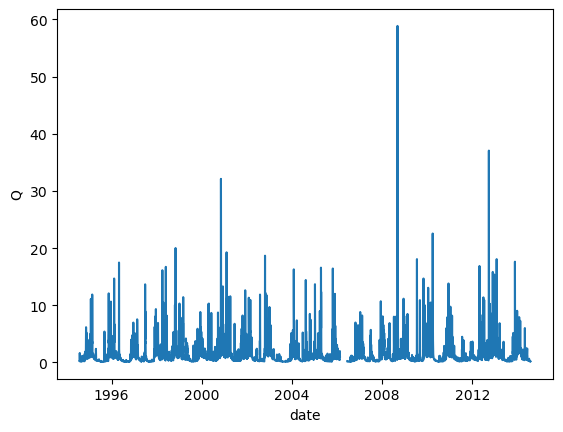

In [14]:
# Quick plot of the observed discharge data.
ds_forcing = xr.open_mfdataset([caravan_forcing_object['Q'],caravan_forcing_object['pr'],caravan_forcing_object['evspsblpot']])
plt.figure()
ds_forcing["Q"].plot()

## Save all settings to a file
Below we create a dict with all the settings we just created and save that to a settings file which is loaded in all the other notebooks of this repo.

In [15]:
# Convert sets to lists for JSON serialization
# serializable_settings = {key: list(value) for key, value in settings.items()}

settings["downloads"] =  str(Path(settings["base_path"]) / "downloads" / settings["caravan_id"])
Path(settings["downloads"]).mkdir(exist_ok=True, parents=True)

# Write to a JSON file
with open(f"regions/{region_id}/settings.json", "w") as json_file:
    json.dump(settings, json_file, indent=4)